# 5. Simple image filtering

In [1]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import IPython.display
%matplotlib widget
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.simple_image_filtering import halfcos, convse

In [2]:
# load the image as we did before
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})

An effective image lowpass filter, of odd length $N$, may be obtained by defining the impulse
response $h(n)$ to be a sampled half-cosine pulse:

$$h(n) = G \cos \left(\frac{n\pi}{N + 1}\right),\qquad \text{for} \qquad \frac{-(N - 1)}{2} \le n \le \frac{N - 1}{2}$$

where $G$ is a gain factor, which, in order to give unity gain at zero frequency, should be calculated such that

$$\sum_{n=-(N-1)/2}^{(N-1)/2} h(n) = 1$$

(This may be done most easily by first calculating h(n) with G = 1, summing all terms,
and then dividing them all by the result.)

Take a look at the `halfcos` function below and check that it generates h for a given N:

In [3]:
# this is just to make it appear in a cell - you can use `halfcos??` to quickly read any function
IPython.display.Code(inspect.getsource(halfcos), language="python")

def halfcos(N: int) -> np.ndarray:
    """
    Create a half-cosine function of length N samples.

    Parameters:
        N: Usually odd.
    Returns:
        h: discrete samples of the half-cosine
    """
    # The amplitude gives unit gain at zero frequency.
    h = np.cos((np.array(range(1, N+1))/(N+1) - 0.5) * np.pi)
    h = h / sum(h)
    return h

Use the [`np.convolve` function in a for loop](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) to convolve a 15-sample half-cosine with each row of the test image, Lighthouse. 

Observe the resulting image `Xf` and note the increased width and the gradual fade to black at the edges, caused by the `convolve` assuming the signal is zero outside the range of the input vectors (the behavior when `mode='full'`).

(256, 256)


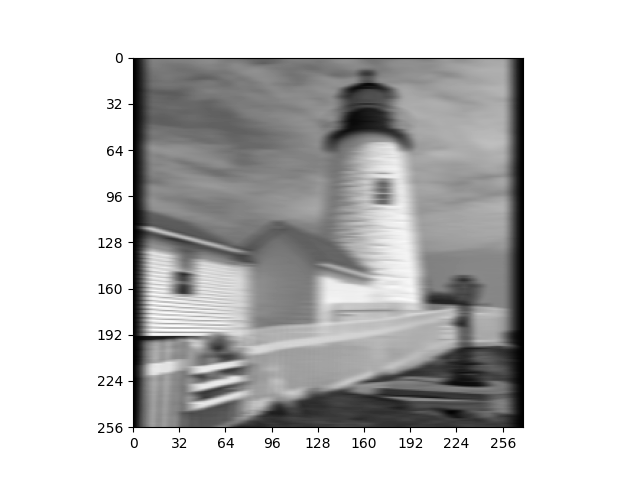

In [4]:
# your code here
print(X.shape)
N = 15
# fig, ax = plt.subplots()
Xf = np.zeros((X.shape[0], X.shape[1]+N-1))
for i in range(X.shape[0]):
    Xf[i, :] = np.convolve(X[i, :], halfcos(15))
fig, ax = plt.subplots()    
plot_image(Xf, ax=ax)
plt.show()

Trim the filtered image `Xf` to its correct size using `Xf[:, 7:256+7]` and display it:

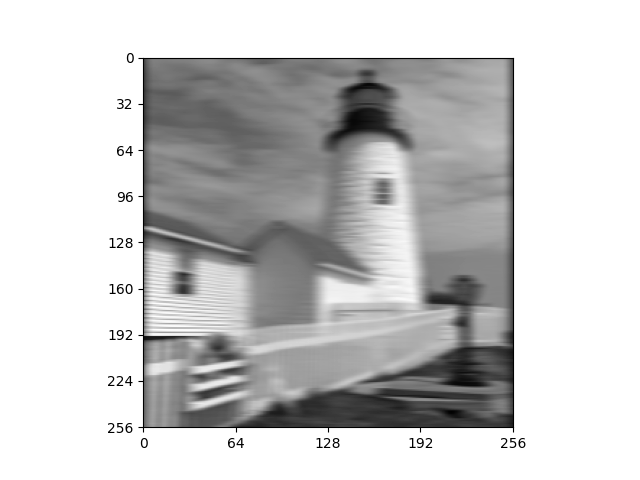

In [5]:
# your code here
fig, ax = plt.subplots()    
plot_image(Xf[:, 7:256+7], ax=ax)

Note that darkening of the sides is still visible, since the lowpass filter
assumes that the intensity is zero outside the image.

Image trimming and convolution of all the image rows can also be achieved using the [`scipy.signal.convolve`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) function with the `mode='same'` argument. Note we have to turn `h` into a 2d filter by wrapping it in `[]`:
```python
Xf = scipy.signal.convolve(X, [h])
```

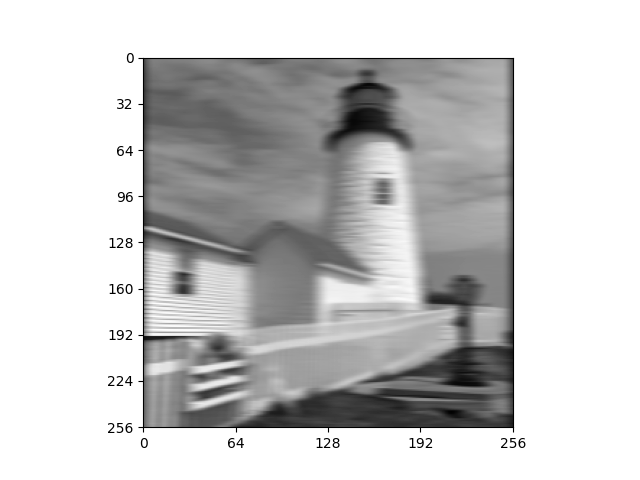

In [6]:
# your code here - use `scipy.signal.convolve` instead of the for loop containing `np.convolve`:
fig, ax = plt.subplots()

# define a 15-sample halfcosine
h = halfcos(15)
Xf = scipy.signal.convolve(X, [h], mode='same')

plot_image(Xf, ax=ax);

Symmetric extension is a technique to minimise edge effects when images of
finite size are filtered.  It assumes that the image is surrounded by a
flat mirror along each edge so it extends into mirror-images (symmetric
extensions) of itself in all directions over an infinite plane.  If the filter
impulse response is symmetrical about its mid point, then the filtered image
will also be symmetrically extended in all directions with the same period as
the original images.  Hence it is only necessary to define the filtered image
over the same area as the original image, for it to be defined over the whole
infinite plane.

Let us consider a one-dimensional example for a 4-point input signal
$a,b,c,d$.  This may be symmetrically extended in one of two ways:

$$
 \ldots d,c,b,\underbrace{a,b,c,d,}_{\text{original}}c,b,a \ldots
\quad \text{or} \quad
 \ldots d,c,b,a,\underbrace{a,b,c,d,}_{\text{original}}d,c,b,a \ldots
$$

The left-hand method, where the end points are not repeated at each boundary, is most
suitable when the signal is to be filtered by a filter of odd length. The other method is most suited to filters of even length.

In Python, a matrix with symmetrically extended rows can be obtained with [`np.pad`](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) using the `reflect` and `symmetric` modes:

In [7]:
x = np.array([
    ["a", "b", "c", "d"],
    ["A", "B", "C", "D"]])
print(np.pad(x, [(0, 0), (2, 2)], mode='reflect'))    # for filters of odd length
print()
print(np.pad(x, [(0, 0), (2, 2)], mode='symmetric'))  # for filters of even length

[['c' 'b' 'a' 'b' 'c' 'd' 'c' 'b']
 ['C' 'B' 'A' 'B' 'C' 'D' 'C' 'B']]

[['b' 'a' 'a' 'b' 'c' 'd' 'd' 'c']
 ['B' 'A' 'A' 'B' 'C' 'D' 'D' 'C']]


Here, `[(0, 0), (2, 2)]` reads as _"pad with 0 entries above and below, and 2 entries to the left and right"_.

The function `convse` make use of this to filter
the rows of matrix `X` using the appropriate form of
symmetric extension. The filtering is performed by accumulating shifted
versions of `X` in `Xe`, each weighted by the appropriate element of
`h`. Check that you understand how this function works.

In [8]:
IPython.display.Code(inspect.getsource(convse), language="python")

def convse(X: np.ndarray, h: np.ndarray) -> np.ndarray:
    """
    Filter rows of image X using filter h with symmetric extension of X.

    Parameters:
        X: Image matrix (Usually 256x256)
        h: Filter coefficients
    Returns:
        Y: Row - Filtered image

    PS: Need to apply `convse` twice to filter rows and columns.
    """
    r, c = X.shape
    m = len(h)
    m2 = m // 2
    if m % 2:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='reflect')
    else:
        X = np.pad(X, [(0, 0), (m2, m2)], mode='symmetric')

    Y = np.zeros((r, c))
    # Loop for each term in h. This loop is the convolution.
    for i in range(m):
        Y = Y + h[i] * X[:, i:i+c]
    return Y

Note that this `convse` is actually provided as part of scipy, as [`scipy.ndimage.convolve1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve1d.html), but `convse` is much easier to understand the implementation of.

Use `convse` to filter the rows of your image with the
15-tap half-cosine filter, noting the absence of edge effects.

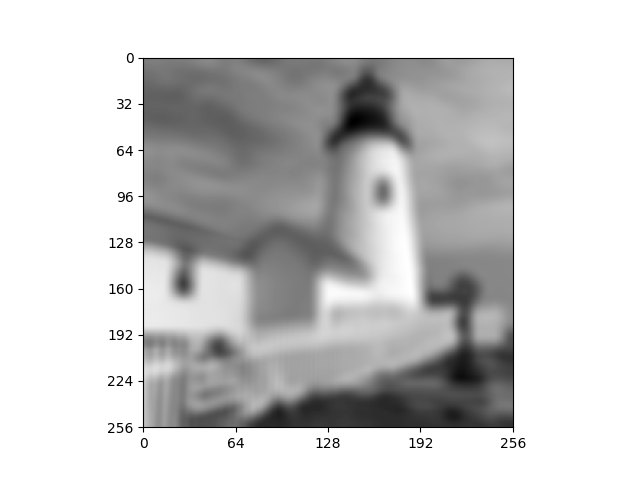

In [9]:
# your code here
h = halfcos(15)
Xe = convse(convse(X, h).T, h).T
fig, ax = plt.subplots()    
plot_image(Xe, ax=ax)

Now filter the columns of the _row-filtered_ image by use of the Python transpose operation `.T`.

(Note that unlike the Matlab version of this lab, the function `conv2se` has not been provided)

<div class="alert alert-block alert-danger">

Does it make any difference whether the rows or columns are filtered first? (You should test this accurately by measuring the maximum absolute pixel difference between the row-column and column-row filtered images. Beware of scientific notation, used by Python for very small numbers!)
    
</div>

[134.797506   134.80026488 134.80348525 134.74995593 134.65327977
 134.50234574 134.27839563 133.9545117  133.51025622 132.96329123
 132.34354131 131.69751865 131.06449895 130.46676189 129.91851818
 129.40967706 128.9665217  128.56996879 128.20376108 127.80386609
 127.35619988 126.84253606 126.25808275 125.59761692 124.87195966
 124.11426686 123.34840866 122.57454097 121.818699   121.11740259
 120.49561277 119.96317359 119.5463689  119.23509188 119.03154739
 118.90132824 118.86677919 118.9028356  119.00290187 119.14604051
 119.29079212 119.42723626 119.54998227 119.60466493 119.60362255
 119.55873471 119.48558641 119.36205122 119.2145518  119.04890978
 118.86579501 118.67935257 118.54039108 118.48136289 118.51318154
 118.65255777 118.89630032 119.22752706 119.66493075 120.16256681
 120.72649024 121.33396157 121.98306694 122.62670302 123.24337668
 123.83308618 124.36514155 124.83079504 125.23497645 125.60466266
 125.94473457 126.28405976 126.62394778 126.98912201 127.40513012
 127.87573

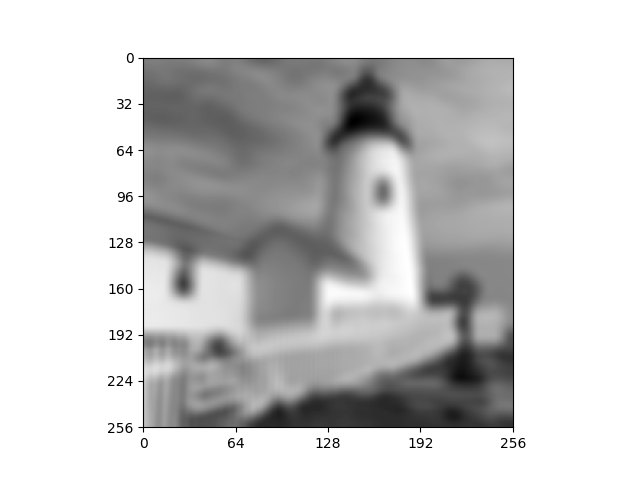

In [10]:
# your code here - Row first
X_T = Xe.T
Xt = convse(convse(X, h).T, h).T
fig, ax = plt.subplots()    
plot_image(Xt, ax=ax)
print(Xt[100])

[134.797506   134.80026488 134.80348525 134.74995593 134.65327977
 134.50234574 134.27839563 133.9545117  133.51025622 132.96329123
 132.34354131 131.69751865 131.06449895 130.46676189 129.91851818
 129.40967706 128.9665217  128.56996879 128.20376108 127.80386609
 127.35619988 126.84253606 126.25808275 125.59761692 124.87195966
 124.11426686 123.34840866 122.57454097 121.818699   121.11740259
 120.49561277 119.96317359 119.5463689  119.23509188 119.03154739
 118.90132824 118.86677919 118.9028356  119.00290187 119.14604051
 119.29079212 119.42723626 119.54998227 119.60466493 119.60362255
 119.55873471 119.48558641 119.36205122 119.2145518  119.04890978
 118.86579501 118.67935257 118.54039108 118.48136289 118.51318154
 118.65255777 118.89630032 119.22752706 119.66493075 120.16256681
 120.72649024 121.33396157 121.98306694 122.62670302 123.24337668
 123.83308618 124.36514155 124.83079504 125.23497645 125.60466266
 125.94473457 126.28405976 126.62394778 126.98912201 127.40513012
 127.87573

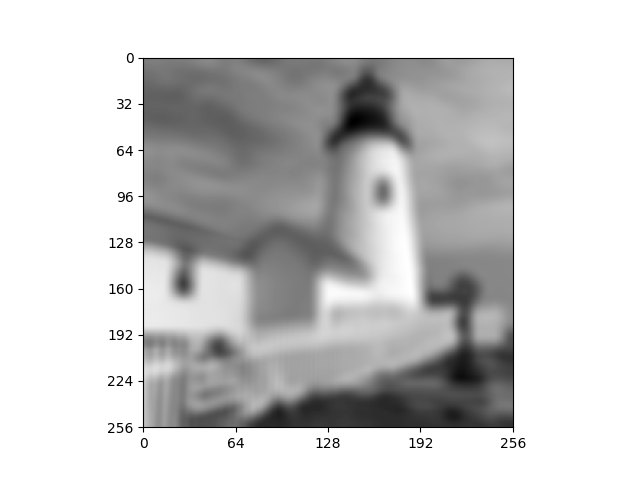

In [11]:
# your code here - Column first
Xc = convse(X.T, halfcos(15))
Xc_T = Xc.T
Xct = convse(Xc_T, halfcos(15))
fig, ax = plt.subplots()    
plot_image(Xct, ax=ax)
print(Xct[100])
diff = np.max(np.abs(Xct-Xt))
print(f'Max difference between row-first and column-first: {diff}')

This process of separate row and column filtering is known as
*separable* 2-D filtering, and is much more efficient than
the more general non-separable 2-D filtering.

It is possible to construct a 2-D _high-pass_ filter by subtracting the 2-D low-pass
result from the original. Note that your 2-D lowpass filter `h` _must_ have a DC gain (sum of all filter coefficients) of unity for this to correctly produce a highpass filter. The
highpass image `Y` now contains negative, as well as positive
pixel values, so it is sensible to display the result using `imshow(Y)` which automatically compensates for this.

<div class="alert alert-block alert-danger">

Try generating both low-pass and high-pass versions of `X` using a range of different odd-length half-cosine filters. Comment on the relative effects of these filters

</div>

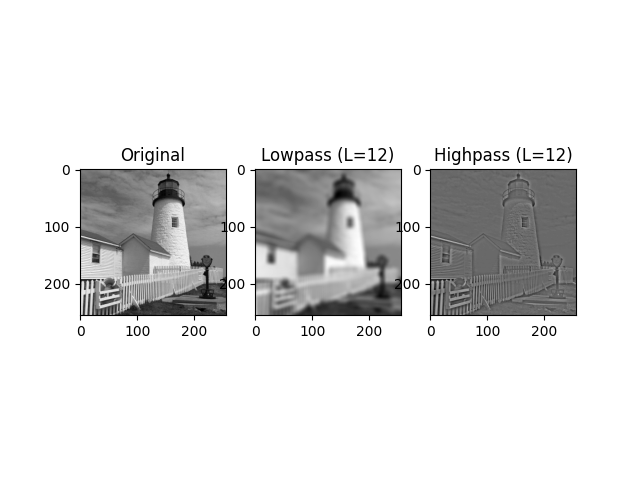

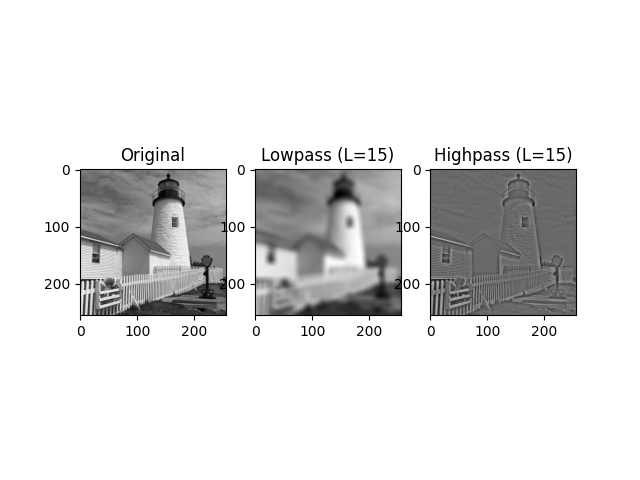

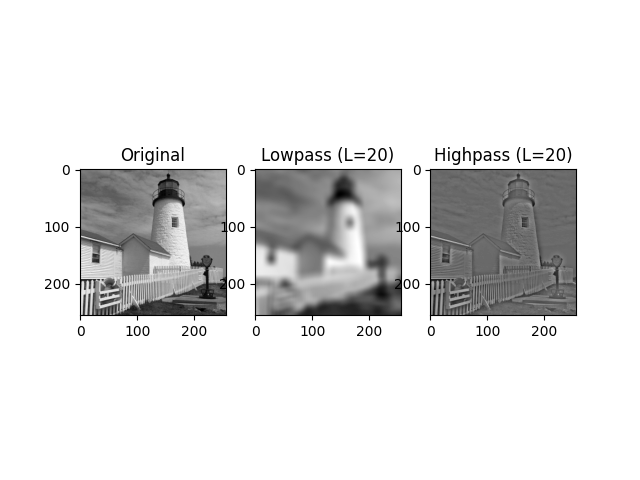

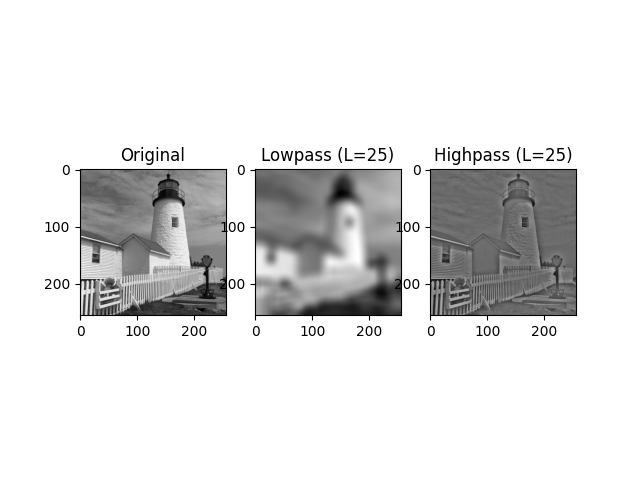

Bad pipe message: %s [b'\xc4\x9e\x82\x00\x1a\xe73\xa8 \xda\xd1B\x07\x0e\xae\xce2\t \xb6I\xcf\xb5\x1cZ\xe0\xe2\xf5\xc4\rg=@D`\xcc\xd0 U\xdb\xf2\xc5']
Bad pipe message: %s [b"\xe8R\xaf\xd5\x18\xe7\x18fy\x98\xfe\xb4k\xcc\xf3H\x91\xc5 \xfa\x8c\xea\xb6I5\xde\xc2)\xe7\xa1\x182J\x80\xf2\xc1'\xb0nX\xe6*\xe9\xbc|\xfavV\xbe\xfcs\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00"]
Bad pipe message: %s [b'\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08']
Bad pipe message: %s [b'|r5h\x96\xc4\xd3#tx\x96{\x96\xdc\xf5\xd3\xd6\x1d\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b"\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'

In [12]:
# your code here
filter_len = [12, 15, 20, 25]
for l in filter_len:
    # Generate the low-pass filter
    h = halfcos(l)
    h = h / l**2
    h = h / np.sum(h)  # Ensure unity DC gain

    # Convolve the image with the low-pass filter
    Yl = convse(convse(X, h).T, h).T

    # Subtract the low-pass filtered result from the original to get the high-pass filter
    Yh = X - Yl

    # Display the results
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(X, cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(Yl, cmap='gray')
    ax[1].set_title(f'Lowpass (L={l})')
    ax[2].imshow(Yh, cmap='gray')
    ax[2].set_title(f'Highpass (L={l})')
    plt.show()

One way to assess sets of filtered images like these is to contrast the *energy* content. In this context, the energy `E` of an image `X` is given by the sum of the squares of the individual pixel values:
```python
E = np.sum(X**2.0)
```
Remember that $a^b$ is spelt `a**b` in Python, not `a^b`. We make sure to use `2.0` and not `2`, as `np.array(16, dtype=np.uint8)**2` overflows the bounds of `uint8` and gives `0`, while `2.0` tells numpy to use at least `float64` instead.

<div class="alert alert-block alert-danger">
What do you observe about the energy of the highpass images, compared with that of the lowpass images?
</div>

In [13]:
# your code here
# Generate the low-pass filter
l = 15
h = halfcos(l)
h = h / l**2
h = h / np.sum(h)  # Ensure unity DC gain

# Convolve the image with the low-pass filter
Yl = convse(convse(X, h).T, h).T

# Subtract the low-pass filtered result from the original to get the high-pass filter
Yh = X - Yl

E_original = np.sum(X**2.0)
E_low = np.sum(Yl**2.0)
E_high = np.sum(Yh**2.0)

print(f'Energy of original: {E_original}')
print(f'Energy of low-pass: {E_low}')
print(f'Energy of high-pass: {E_high}')

Energy of original: 1317349829.0
Energy of low-pass: 1255989103.036688
Energy of high-pass: 47950210.247288465
